In [2]:
import sys
sys.path.append('.')

import os
import random

import torch
import torch.utils.data as data
import numpy as np
import open3d as o3d

In [3]:
class ShapeNet(data.Dataset):
    """
    ShapeNet dataset in "PCN: Point Completion Network". It contains 28974 training
    samples while each complete samples corresponds to 8 viewpoint partial scans, 800
    validation samples and 1200 testing samples.
    """

    def __init__(self, dataroot, split, category):
        assert split in ['train', 'valid', 'test', 'test_novel'], "split error value!"

        self.cat2id = {
            # seen categories
            "airplane"  : "02691156",  # plane
            "cabinet"   : "02933112",  # dresser
            "car"       : "02958343",
            "chair"     : "03001627",
            "lamp"      : "03636649",
            "sofa"      : "04256520",
            "table"     : "04379243",
            "vessel"    : "04530566",  # boat

            # alis for some seen categories
            "boat"      : "04530566",  # vessel
            "couch"     : "04256520",  # sofa
            "dresser"   : "02933112",  # cabinet
            "airplane"  : "02691156",  # airplane
            "watercraft": "04530566",  # boat

            # unseen categories
            "bus"       : "02924116",
            "bed"       : "02818832",
            "bookshelf" : "02871439",
            "bench"     : "02828884",
            "guitar"    : "03467517",
            "motorbike" : "03790512",
            "skateboard": "04225987",
            "pistol"    : "03948459",
        }

        # self.id2cat = {cat_id: cat for cat, cat_id in self.cat2id.items()}

        self.dataroot = dataroot
        self.split = split
        self.category = category

        self.partial_paths, self.complete_paths = self._load_data()

    def __getitem__(self, index):
        if self.split == 'train':
            partial_path = self.partial_paths[index].format(random.randint(0, 7))
        else:
            partial_path = self.partial_paths[index]
        complete_path = self.complete_paths[index]

        # get the point cloud without random sampling and return them
        partial_pc = self.read_point_cloud(partial_path)
        complete_pc = self.read_point_cloud(complete_path)

        # partial_pc = self.random_sample(self.read_point_cloud(partial_path), 2048)
        # complete_pc = self.random_sample(self.read_point_cloud(complete_path), 16384)

        return torch.from_numpy(partial_pc), torch.from_numpy(complete_pc)

    def __len__(self):
        return len(self.complete_paths) # 3795

    def _load_data(self):
        with open(os.path.join(self.dataroot, '{}.list').format(self.split), 'r') as f:
            lines = f.read().splitlines()

        if self.category != 'all':
            lines = list(filter(lambda x: x.startswith(self.cat2id[self.category]), lines))

        partial_paths, complete_paths = list(), list()

        for line in lines:
            category, model_id = line.split('/')
            if self.split == 'train':
                partial_paths.append(os.path.join(self.dataroot, self.split, 'partial', category, model_id + '_{}.ply'))
            else:
                partial_paths.append(os.path.join(self.dataroot, self.split, 'partial', category, model_id + '.ply'))
            complete_paths.append(os.path.join(self.dataroot, self.split, 'complete', category, model_id + '.ply'))

        return partial_paths, complete_paths

    def read_point_cloud(self, path):
        pc = o3d.io.read_point_cloud(path)
        return np.array(pc.points, np.float32)

    def random_sample(self, pc, n):
        idx = np.random.permutation(pc.shape[0])
        if idx.shape[0] < n:
            idx = np.concatenate([idx, np.random.randint(pc.shape[0], size=n-pc.shape[0])])
        return pc[idx[:n]]

In [8]:
dataset = ShapeNet('../data/PCN', 'train', 'airplane')
ds_len = len(dataset)
print(ds_len)
partial_pc_num_pt_list = []
complete_pc_num_pt_list = []
for i in range(ds_len):
    if i % 100 == 0:
        print(i)
    partial_pc, complete_pc = dataset[i]
    partial_pc_num_pt_list.append(partial_pc.shape[0])
    complete_pc_num_pt_list.append(complete_pc.shape[0])

# print average of partial_pc and complete_pc
print(np.mean(partial_pc_num_pt_list), np.mean(complete_pc_num_pt_list))
# print std of partial_pc and complete_pc
print(np.std(partial_pc_num_pt_list), np.std(complete_pc_num_pt_list))
# print(partial_pc.min(), partial_pc.max())
# print(complete_pc.min(), complete_pc.max())
# # print std of partial_pc and complete_pc
# print(partial_pc.std(), complete_pc.std())

# # print mean of partial_pc and complete_pc
# print(partial_pc.mean(), complete_pc.mean())

3795
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
1174.933860342556 16384.0
339.93188436454057 0.0


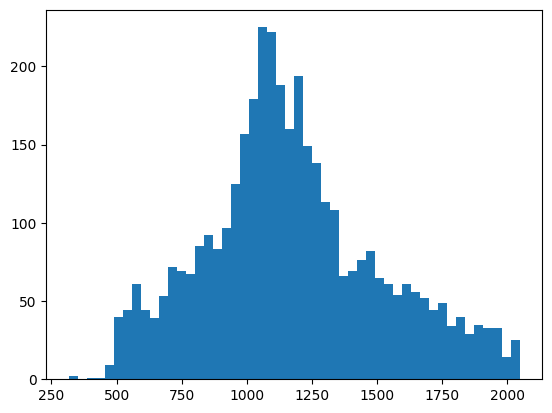

In [9]:
# plot the distribution of partial_pc number of points
import matplotlib.pyplot as plt
plt.hist(partial_pc_num_pt_list, bins=50)
plt.show()

In [11]:
# print max of partial_pc number of points
print(max(partial_pc_num_pt_list))

# print the median of partial_pc number of points
print(np.median(partial_pc_num_pt_list))

2047
1138.0
